In [1]:
# -----------------------------
# Imports & Setup
# -----------------------------
import pandas as pd
from pathlib import Path
import sys
import joblib


from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


project_root = Path.cwd().resolve().parent 
sys.path.append(str(project_root))

from src.data.loader import FraudDataLoader
from src.explainability import ModelExplainability
from src.utils.io_utils import save_dataframe


In [2]:
# -------------------------------
# Features
# -------------------------------
NUMERIC_FEATURES = [
    'purchase_value',
    'age',
    'hour_of_day',
    'day_of_week',
    'time_since_signup',
    'transactions_per_user',
    'transactions_last_24h'
]

CATEGORICAL_FEATURES = ['source', 'browser', 'sex', 'country']
TARGET = 'class'

In [3]:
model_path = "../models/random_forest_fraud.joblib"
preprocessor_path = "../models/preprocessor_fraud.joblib"

# Load feature-engineered data
fraud_df = FraudDataLoader("../data/processed/fraud_data_with_features.csv").load()

# Initialize explainability class
explainer = ModelExplainability(
    model_path=model_path,
    preprocessor_path=preprocessor_path,
    X=fraud_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES],
    y=fraud_df[TARGET]
)

2025-12-30 21:23:46,996 - INFO - Initializing ModelExplainability
2025-12-30 21:23:48,491 - INFO - ModelExplainability initialized successfully


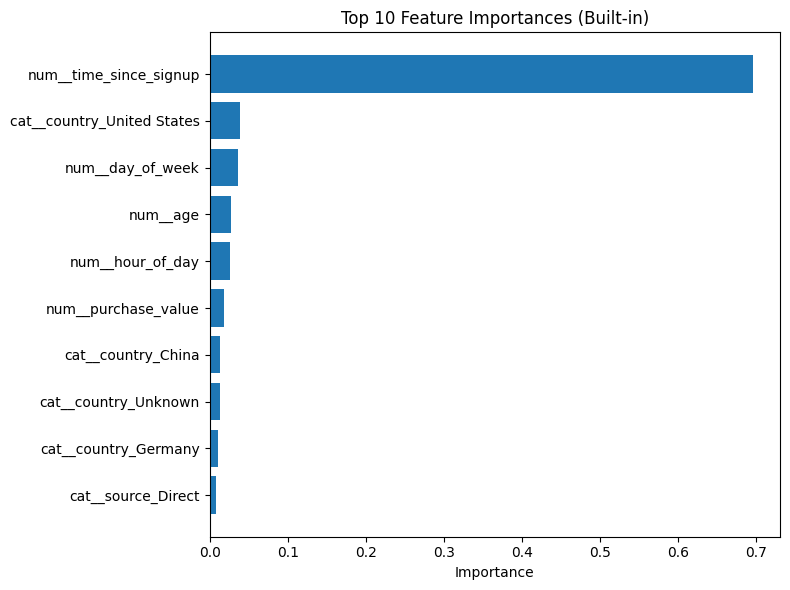

,feature,importance
4,num__time_since_signup,0.695327
185,cat__country_United States,0.038534
3,num__day_of_week,0.036609
1,num__age,0.026904
2,num__hour_of_day,0.026221
0,num__purchase_value,0.018200
52,cat__country_China,0.013447
186,cat__country_Unknown,0.013177
80,cat__country_Germany,0.010421
8,cat__source_Direct,0.008067


In [4]:
# ----------------------------
# Built-in feature importance (RF only)
# ----------------------------
explainer.plot_builtin_feature_importance()

2025-12-30 21:23:48,860 - INFO - Computing SHAP values
2025-12-30 21:23:48,875 - INFO - Using TreeExplainer


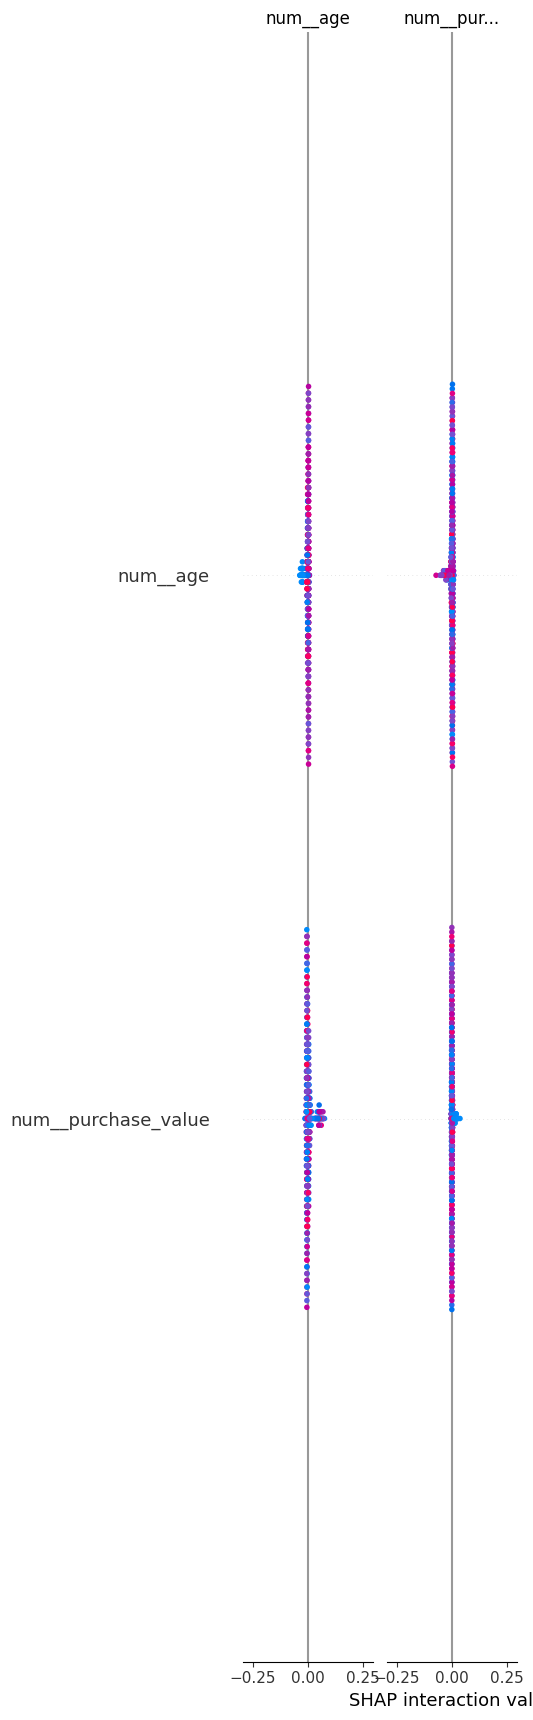

In [5]:
# ----------------------------
# SHAP Summary Plot
# ----------------------------
explainer.plot_shap_summary()

In [6]:
# ----------------------------
# SHAP Force Plots for key cases
# ----------------------------
explainer.plot_force_plot_for_case("TP")


2025-12-30 21:23:54,946 - INFO - Generating force plot for case: TP


In [7]:
explainer.plot_force_plot_for_case("FP")


2025-12-30 21:23:55,014 - INFO - Generating force plot for case: FP


In [8]:
explainer.plot_force_plot_for_case("FN")

2025-12-30 21:23:55,047 - INFO - Generating force plot for case: FN


In [9]:
# ----------------------------
# Top 5 SHAP Drivers
# ----------------------------
top_drivers = explainer.get_top_drivers()
print(top_drivers)


2025-12-30 21:23:55,087 - INFO - Detected 3D SHAP array, selecting positive class (index 1)


                        feature  mean_abs_shap
4        num__time_since_signup       0.110404
185  cat__country_United States       0.020850
3              num__day_of_week       0.009484
2              num__hour_of_day       0.004649
10          cat__browser_Chrome       0.004402


## 🔍 Interpretation of SHAP Results (Fraud Detection)

The SHAP analysis reveals that **temporal and behavioral features dominate fraud predictions**, rather than purely transactional attributes.

The strongest driver of fraud predictions is **`time_since_signup`**, with a mean absolute SHAP value of **0.1104**, far exceeding all other features. This indicates that **newly created accounts are significantly more likely to be involved in fraudulent transactions**, which aligns with common fraud patterns where attackers exploit accounts shortly after registration.

The presence of **`country = United States`** as the second most influential feature is notable. Rather than implying that U.S.-based users are inherently fraudulent, this likely reflects **dataset exposure bias** or **fraud targeting high-volume markets**, where attackers blend into regions with high transaction density to reduce detection.

Temporal features such as **`day_of_week`** and **`hour_of_day`** also contribute meaningfully to predictions. This suggests that fraud activity follows **distinct timing patterns**, potentially concentrated during **off-business hours or specific days** when monitoring is weaker or user behavior deviates from the norm.

Finally, **`browser = Chrome`** appears among the top drivers. This is not inherently suspicious on its own, but it may act as a **proxy feature**, capturing automated tools or scripts that mimic popular browsers to evade detection.

Overall, SHAP provides clearer behavioral insights than built-in feature importance by highlighting **how features push individual predictions**, rather than merely ranking features by split frequency.

---

## ⚖️ Comparison: SHAP vs Built-in Feature Importance

While built-in feature importance highlights features that are frequently used by the model, SHAP reveals **how consistently and directionally those features influence fraud predictions**.

Notably, `time_since_signup` not only ranks highly in both methods but also shows **large, consistent contributions across individual fraud cases**, making it a more reliable risk indicator than features like country or browser, whose effects are more context-dependent.

This demonstrates why SHAP is essential for fraud models: it exposes **behavioral causality**, not just model structure.

---

## 🧠 Top 5 Drivers of Fraud Predictions (from SHAP)

1. **Time since signup** – Newly created accounts carry the highest fraud risk
2. **Country (United States)** – Likely reflects market volume and attacker camouflage
3. **Day of week** – Fraud patterns vary across weekdays and weekends
4. **Hour of day** – Off-hour transactions show elevated risk
5. **Browser (Chrome)** – Potential proxy for automation or scripted activity

---

## 💼 Business Recommendations (Actionable & SHAP-Driven)

1. **Apply enhanced verification to new accounts**
   Transactions occurring within the first **X hours/days after signup** should trigger step-up authentication or spending limits, as SHAP shows early-lifecycle activity strongly increases fraud risk.

2. **Introduce time-based fraud rules**
   Transactions occurring during **high-risk hours or days** identified by SHAP (e.g., late night or weekends) should receive increased monitoring or dynamic risk scoring.

3. **Monitor high-volume regions more closely**
   Rather than blocking by country, apply **adaptive risk thresholds** for regions with high transaction volume (e.g., U.S.), where attackers may hide among legitimate users.

4. **Flag suspicious browser behavior patterns**
   Repeated high-value transactions from popular browsers (e.g., Chrome) combined with other risk factors (new account + odd hours) should trigger investigation, as SHAP indicates browser context contributes to fraud decisions.
